In [2]:
import numpy as np
import keras
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Conv2D, BatchNormalization, Dropout, MaxPool2D, Input, Softmax, Activation, Flatten
from keras.models import Model
from keras import optimizers
from keras.layers import concatenate,AveragePooling2D
import os
print(os.listdir("ECG"))
import cv2
import scipy
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

['.DS_Store', 'STPDDM_Result', '20170803RR_raw_Data']


In [8]:
from tqdm import tqdm
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    z = []
    for ecg_type in os.listdir(folder):
        if not ecg_type.startswith('.'):
            if ecg_type in ['chf']:
                label = 1
                label2 = 1
            elif ecg_type in ['nsr']:
                label = 2
                label2 = 1
           # elif wbc_type in ['MONOCYTE']:
             #   label = 3  
              #  label2 = 0
            #elif wbc_type in ['LYMPHOCYTE']:
             #   label = 4 
              #  label2 = 0
            else:
                label = 3
                label2 = 0
            for image_filename in tqdm(os.listdir(folder + ecg_type)):
                img_file = cv2.imread(folder + ecg_type + '/' + image_filename)
                if img_file is not None:
                    img_file = scipy.misc.imresize(arr=img_file, size=(60, 80, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
                    z.append(label2)
    X = np.asarray(X)
    y = np.asarray(y)
    z = np.asarray(z)
    return X,y,z
X_train, y_train, z_train = get_data('ECG/STPDDM_Result/train/')
X_test, y_test, z_test = get_data('ECG/STPDDM_Result/test/')

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 3)
y_testHot = to_categorical(y_test, num_classes = 3)
z_trainHot = to_categorical(z_train, num_classes = 2)
z_testHot = to_categorical(z_test, num_classes = 2)
dict_characters = {1:'chf',2:'nsr'}
dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}
print(dict_characters)
print(dict_characters2)

  0%|          | 0/223 [00:00<?, ?it/s]/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
100%|██████████| 62/62 [00:00<00:00, 184.36it/s]

{1: 'chf', 2: 'nsr'}
{0: 'Mononuclear', 1: 'Polynuclear'}


In [22]:
def keras_model(block_num=2):
    inp = Input(shape=(60,80,3))
    k = BatchNormalization()(inp)
    k = Conv2D(32, (7,7), padding="same",activation="relu",strides=(2,2))(k)
    k = MaxPool2D(pool_size=(3, 3), padding="same",strides=(2,2))(k) 
    k = Conv2D(32, (3,3), padding="same",activation="relu",strides=(1,1))(k)
    k = MaxPool2D(pool_size=(3, 3), padding="same",strides=(2,2))(k)
    for j in range(1,block_num+1):
        out_conv = []
        for i in [(1,1),(3,3),(5,5),(0,0)]:
            p = k
            if i == (1,1):
                p = Conv2D(32, (1,1), padding="same",activation="relu")(p)
                out_conv.append(Conv2D(32, (1,1), padding="same",activation="relu")(p))
            elif i == (0,0):
                p = MaxPool2D(pool_size=(2, 2), padding="same",strides=(1,1))(p)
                out_conv.append(Conv2D(32, (1,1), padding="same",activation="relu")(p))
            else:
                p = Conv2D(32, (1,1), padding="same",activation="relu")(p)
                p = Conv2D(32, i, padding="same",activation="relu")(p)
                out_conv.append(Conv2D(32, i, padding="same",activation="relu")(p))
        x = concatenate(out_conv, axis = -1)
        #if j%2 == 0:
        #    x = MaxPool2D(pool_size=(3, 3), padding="same",strides=(2,2))(x)
        #x = BatchNormalization(axis=-1)(x)
        k = x
   # x = Dropout(0.5)(k)
    x = MaxPool2D(pool_size=(7, 7), padding="same",strides=(2,2))(x)
    x = Flatten()(x)
    #x = Dense(1024,activation="relu")(x)
    #x = BatchNormalization()(x)
    #x = Dropout(0.5)(x)
    y = Dense(3,activation="softmax")(x)
#    z = Dense(2,activation="softmax")(x)
    model = Model(inp, y)
    opt = optimizers.Adam(lr=0.01,decay=0.0001)
    model.compile(loss='categorical_crossentropy',
                  optimizer="adam",
                  metrics=['accuracy'])
    return model
model = keras_model(4)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 60, 80, 3)    0                                            
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 60, 80, 3)    12          input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_115 (Conv2D)             (None, 30, 40, 32)   4736        batch_normalization_4[0][0]      
__________________________________________________________________________________________________
max_pooling2d_22 (MaxPooling2D) (None, 15, 20, 32)   0           conv2d_115[0][0]                 
__________________________________________________________________________________________________
conv2d_116

In [26]:
filepath = "./weight_tr5.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit(X_train,
         y_trainHot,
         epochs = 60,
         batch_size = 32,
         validation_data = (X_test,y_testHot),
         callbacks = callbacks_list,
         verbose = 1)

Train on 654 samples, validate on 108 samples
Epoch 1/60
654/654 [==============================] - 3s 5ms/step - loss: 0.0701 - acc: 0.9725 - val_loss: 0.4884 - val_acc: 0.8796

Epoch 00001: val_acc improved from -inf to 0.87963, saving model to ./weight_tr5.hdf5
Epoch 2/60
654/654 [==============================] - 3s 5ms/step - loss: 0.0272 - acc: 0.9924 - val_loss: 0.5286 - val_acc: 0.8519

Epoch 00002: val_acc did not improve from 0.87963
Epoch 3/60
654/654 [==============================] - 3s 5ms/step - loss: 0.0041 - acc: 1.0000 - val_loss: 0.5699 - val_acc: 0.8796

Epoch 00003: val_acc did not improve from 0.87963
Epoch 4/60
654/654 [==============================] - 3s 5ms/step - loss: 9.3016e-04 - acc: 1.0000 - val_loss: 0.5857 - val_acc: 0.8889

Epoch 00004: val_acc improved from 0.87963 to 0.88889, saving model to ./weight_tr5.hdf5
Epoch 5/60
654/654 [==============================] - 3s 5ms/step - loss: 7.1235e-04 - acc: 1.0000 - val_loss: 0.6273 - val_acc: 0.8796

Epoch 

654/654 [==============================] - 3s 5ms/step - loss: 2.0885e-05 - acc: 1.0000 - val_loss: 0.7438 - val_acc: 0.8981

Epoch 00044: val_acc did not improve from 0.89815
Epoch 45/60
654/654 [==============================] - 3s 5ms/step - loss: 2.1830e-05 - acc: 1.0000 - val_loss: 0.7439 - val_acc: 0.8981

Epoch 00045: val_acc did not improve from 0.89815
Epoch 46/60
654/654 [==============================] - 3s 5ms/step - loss: 1.9479e-05 - acc: 1.0000 - val_loss: 0.7452 - val_acc: 0.8981

Epoch 00046: val_acc did not improve from 0.89815
Epoch 47/60
654/654 [==============================] - 4s 6ms/step - loss: 1.8828e-05 - acc: 1.0000 - val_loss: 0.7469 - val_acc: 0.8981

Epoch 00047: val_acc did not improve from 0.89815
Epoch 48/60
654/654 [==============================] - 3s 5ms/step - loss: 1.9667e-05 - acc: 1.0000 - val_loss: 0.7474 - val_acc: 0.8981

Epoch 00048: val_acc did not improve from 0.89815
Epoch 49/60
654/654 [==============================] - 3s 5ms/step - los

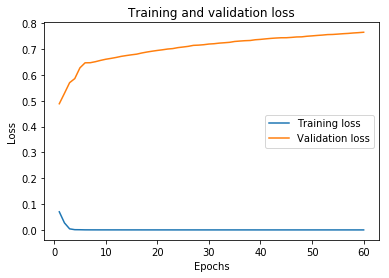

In [28]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

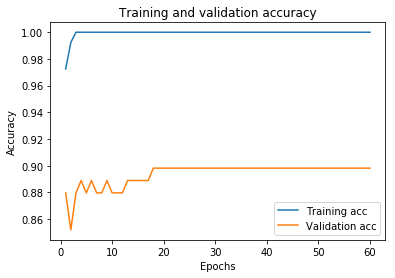

In [29]:
#Accuracy Plot
history_dict = history.history
history_dict.keys()
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [35]:
## Loading Best Weights from the Gang
model.load_weights(filepath)
from keras.preprocessing.image import ImageDataGenerator
datagentrain = ImageDataGenerator(featurewise_center=False,
                samplewise_center=False,
                featurewise_std_normalization=False,
                samplewise_std_normalization=False,
                zca_whitening=False, zca_epsilon=1e-06,
                rotation_range=5, width_shift_range=0.0,
                height_shift_range=0.0, brightness_range=None,
                shear_range=0, zoom_range=0.0,
                channel_shift_range=0.0, fill_mode='nearest',
                cval=0.0, horizontal_flip=True, vertical_flip=True,
                rescale=None, preprocessing_function=None,
                data_format=None, validation_split=0.0)
datagentrain.fit(X_train)
history = model.fit_generator(datagentrain.flow(X_train, y_trainHot, batch_size=32),
                    steps_per_epoch=64,
                    epochs=10,
                    workers=4,
                    use_multiprocessing=True,validation_data = (X_test,y_testHot),
         callbacks = callbacks_list,)

Epoch 1/10
64/64 [==============================] - 10s 162ms/step - loss: 1.8681 - acc: 0.6675 - val_loss: 6.8651 - val_acc: 0.5741

Epoch 00001: val_acc did not improve from 0.89815
Epoch 2/10
64/64 [==============================] - 10s 153ms/step - loss: 5.6883 - acc: 0.6471 - val_loss: 6.8651 - val_acc: 0.5741

Epoch 00002: val_acc did not improve from 0.89815
Epoch 3/10
64/64 [==============================] - 10s 151ms/step - loss: 5.1991 - acc: 0.6774 - val_loss: 6.8651 - val_acc: 0.5741

Epoch 00003: val_acc did not improve from 0.89815
Epoch 4/10
64/64 [==============================] - 10s 150ms/step - loss: 5.2936 - acc: 0.6716 - val_loss: 6.8651 - val_acc: 0.5741

Epoch 00004: val_acc did not improve from 0.89815
Epoch 5/10
64/64 [==============================] - 10s 161ms/step - loss: 5.6980 - acc: 0.6465 - val_loss: 6.8651 - val_acc: 0.5741

Epoch 00005: val_acc did not improve from 0.89815
Epoch 6/10
64/64 [==============================] - 11s 164ms/step - loss: 5.270

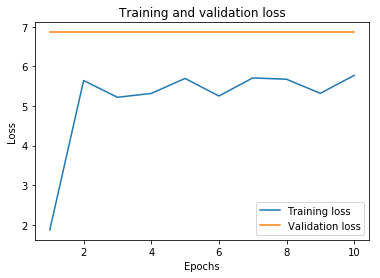

In [36]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

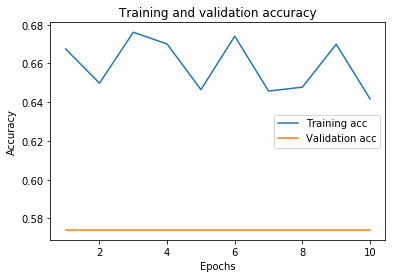

In [37]:
#Accuracy Plot
history_dict = history.history
history_dict.keys()
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [38]:
from tqdm import tqdm
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    z = []
    for ecg_type in os.listdir(folder):
        if not ecg_type.startswith('.'):
            if ecg_type in ['chf']:
                label = 1
                label2 = 1
            elif ecg_type in ['nsr']:
                label = 2
                label2 = 1
           # elif wbc_type in ['MONOCYTE']:
             #   label = 3  
              #  label2 = 0
            #elif wbc_type in ['LYMPHOCYTE']:
             #   label = 4 
              #  label2 = 0
            else:
                label = 3
                label2 = 0
            for image_filename in tqdm(os.listdir(folder + ecg_type)):
                img_file = cv2.imread(folder + ecg_type + '/' + image_filename)
                if img_file is not None:
                    img_file = scipy.misc.imresize(arr=img_file, size=(60, 80, 3))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
                    z.append(label2)
    X = np.asarray(X)
    y = np.asarray(y)
    z = np.asarray(z)
    return X,y,z
X_train, y_train, z_train = get_data('ECG/STPDDM_Result/test/')
X_test, y_test, z_test = get_data('ECG/STPDDM_Result/train/')

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 3)
y_testHot = to_categorical(y_test, num_classes = 3)
z_trainHot = to_categorical(z_train, num_classes = 2)
z_testHot = to_categorical(z_test, num_classes = 2)
dict_characters = {1:'chf',2:'nsr'}
dict_characters2 = {0:'Mononuclear',1:'Polynuclear'}
print(dict_characters)
print(dict_characters2)

  0%|          | 0/46 [00:00<?, ?it/s]/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
100%|██████████| 431/431 [00:02<00:00, 151.49it/s]

{1: 'chf', 2: 'nsr'}
{0: 'Mononuclear', 1: 'Polynuclear'}


In [41]:
filepath = "./weight_tr5.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit(X_train,
         y_trainHot,
         epochs = 60,
         batch_size = 2,
         validation_data = (X_test,y_testHot),
         callbacks = callbacks_list,
         verbose = 1)

Train on 108 samples, validate on 654 samples
Epoch 1/60
108/108 [==============================] - 2s 23ms/step - loss: 6.8651 - acc: 0.5741 - val_loss: 5.4959 - val_acc: 0.6590

Epoch 00001: val_acc improved from -inf to 0.65902, saving model to ./weight_tr5.hdf5
Epoch 2/60
108/108 [==============================] - 2s 22ms/step - loss: 6.8651 - acc: 0.5741 - val_loss: 5.4959 - val_acc: 0.6590

Epoch 00002: val_acc did not improve from 0.65902
Epoch 3/60
108/108 [==============================] - 2s 21ms/step - loss: 6.8651 - acc: 0.5741 - val_loss: 5.4959 - val_acc: 0.6590

Epoch 00003: val_acc did not improve from 0.65902
Epoch 4/60
108/108 [==============================] - 2s 21ms/step - loss: 6.8651 - acc: 0.5741 - val_loss: 5.4959 - val_acc: 0.6590

Epoch 00004: val_acc did not improve from 0.65902
Epoch 5/60
108/108 [==============================] - 2s 22ms/step - loss: 6.8651 - acc: 0.5741 - val_loss: 5.4959 - val_acc: 0.6590

Epoch 00005: val_acc did not improve from 0.6590

108/108 [==============================] - 2s 21ms/step - loss: 6.8651 - acc: 0.5741 - val_loss: 5.4959 - val_acc: 0.6590

Epoch 00045: val_acc did not improve from 0.65902
Epoch 46/60
108/108 [==============================] - 2s 22ms/step - loss: 6.8651 - acc: 0.5741 - val_loss: 5.4959 - val_acc: 0.6590

Epoch 00046: val_acc did not improve from 0.65902
Epoch 47/60
108/108 [==============================] - 2s 21ms/step - loss: 6.8651 - acc: 0.5741 - val_loss: 5.4959 - val_acc: 0.6590

Epoch 00047: val_acc did not improve from 0.65902
Epoch 48/60
108/108 [==============================] - 2s 22ms/step - loss: 6.8651 - acc: 0.5741 - val_loss: 5.4959 - val_acc: 0.6590

Epoch 00048: val_acc did not improve from 0.65902
Epoch 49/60
108/108 [==============================] - 2s 21ms/step - loss: 6.8651 - acc: 0.5741 - val_loss: 5.4959 - val_acc: 0.6590

Epoch 00049: val_acc did not improve from 0.65902
Epoch 50/60
108/108 [==============================] - 2s 23ms/step - loss: 6.8651 - ac